In [24]:
import numpy             as     np
import math
import matplotlib.pyplot as     plt
from   astropy.table     import Table
from   astropy.cosmology import FlatLambdaCDM
from   matplotlib.pyplot import cm
import matplotlib
from   scipy.special     import gamma
from   scipy             import interpolate
import pickle
import time
import progressbar

#For making multiple page pdfs
from matplotlib.backends.backend_pdf import PdfPages

In [25]:
# _________________________________________________________
# _________________________________________________________
#-- Helful Functions --#
#                                       ... must always run
# _________________________________________________________

def ConstantV(R,Vmax):
    return np.repeat(Vmax,len(R))


def NumericalIntegral(R,Func):
    '''
    This integrates a function numerically, within the maximum R value given.
    
    Parameters
    ----------
    R : array
        Radial values of the function
        
    Func: array
        Values of a function at each radii that is to be integrated numerically
    
    Returns
    -------
    float 
        Gives the numerical integral within the maximum R value
    '''
    i = range(0,len(R)-1)
    one = np.repeat(1,len(R)-1)
    return np.nansum(np.nanmean([Func[i],Func[i+one]])*(R[i+one]-R[i]))


def TotalSpecificAM(R,SD,RC):
    '''
    Calculates the TOTAL specific angular momentum, given a surface density profile and rotation curve
        
    R is the radii values 
    SD is the surface density profile
    RC is the rotation curve
    '''

    AM = NumericalIntegral(R,RC*SD*(R**2))
    S_AM = AM/NumericalIntegral(R,SD*R)
    return S_AM

def TotalSpecificAM_bnr(R,SD_tot,SD_disk,RC):
    '''
    Calculates the TOTAL specific angular momentum, given a surface density profile and rotation curve assuming that the bulge isn't rotating. 
    Hence, a Surface density for the total profile and the disk component only are both needed.
        
    R is the radii values 
    SD is the surface density profile
    RC is the rotation curve
    '''

    AM = NumericalIntegral(R,RC*SD_disk*(R**2))
    S_AM = AM/NumericalIntegral(R,SD_tot*R)
    return S_AM

def inclination(axrat,q0):
    return np.arccos(np.sqrt((axrat**2 - q0**2)/(1-q0**2)))*180/np.pi

def intersection(lst1, lst2):
    '''
    A function I got off stack exchange for finding the intersection of two lists.
    '''
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def save_obj(obj, name ):
    '''
    code taken from: https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file/32216025
    It saves an object to a pickel file (I think?)
    
    name should be a string version of obj name (I think)
    '''
    with open(path+'obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    '''
    code taken from: https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file/32216025
    It saves an object to a pickel file (I think?)
    
    name should be a string version of obj name (I think)
    '''
    with open(path+'obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [26]:
# _________________________________________________________
# _________________________________________________________
#-- Import files Part 1--#
#                                       ... must always run
# _________________________________________________________

#First import the catalogue into an astropy.table (This is the catalogue I made with physical units included)
print('Reading in catalogues...')

#Path where all the files are for this/ where this code is located
#path = '/Users/jenniferhardwick/Desktop/OneDrive - The University of Western Australia/PhD/xGASS_Decomposition_Catalogue/'
path = '/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/xGASS_Decomposition_Catalogue/'

#-------
#-------
#Switch to True or False depending if you want to have MW Extinction
MW_Extinction_On = True
#-------
#-------

# --
#Loading files from "2_BuildingProfiles_of_xGASS.ipynb"
if MW_Extinction_On:
    #MW Extinction
    mydata = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v2.fits')
    I_wrt_r    = load_obj('I_wrt_r+MWExtinction')
    I_within_r = load_obj('I_within_r+MWExtinction')

    sd     = load_obj('sd+MWExtinction')
    SD_abs = load_obj('SD_abs+MWExtinction')
    R      = load_obj('R+MWExtinction')
    R_kpc  = load_obj('R_kpc+MWExtinction')

    logMstar_wrt_r     = load_obj('logMstar_wrt_r+MWExtinction')
    logMstar_wrt_r_fix = load_obj('logMstar_wrt_r_fix+MWExtinction')
    g_i_colour         = load_obj('g_i_colour+MWExtinction')
    g_i_colour_fix     = load_obj('g_i_colour_fix+MWExtinction')

    logMstar_within_r     = load_obj('logMstar_within_r+MWExtinction')
    logMstar_within_r_fix = load_obj('logMstar_within_r_fix+MWExtinction')

    TotMstar_recover     = load_obj('TotMstar_recover+MWExtinction')
    TotMstar_recover_fix = load_obj('TotMstar_recover_fix+MWExtinction')

else:
    #No MW Extinction
    mydata = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v2.fits')
    I_wrt_r    = load_obj('I_wrt_r')
    I_within_r = load_obj('I_within_r')

    sd     = load_obj('sd')
    SD_abs = load_obj('SD_abs')
    R      = load_obj('R')
    R_kpc  = load_obj('R_kpc')

    logMstar_wrt_r     = load_obj('logMstar_wrt_r')
    logMstar_wrt_r_fix = load_obj('logMstar_wrt_r_fix')
    g_i_colour         = load_obj('g_i_colour')
    g_i_colour_fix     = load_obj('g_i_colour_fix')

    logMstar_within_r     = load_obj('logMstar_within_r')
    logMstar_within_r_fix = load_obj('logMstar_within_r_fix')

    TotMstar_recover     = load_obj('TotMstar_recover')
    TotMstar_recover_fix = load_obj('TotMstar_recover_fix')



#--
        
print('Catalogues loaded')

Reading in catalogues...
Catalogues loaded


In [27]:
# _________________________________________________________
# _________________________________________________________
#-- Import files Part 2--#
#                                       ... must always run
# _________________________________________________________

print('Reading in catalogues...')

#--
#Loading files from the xGASS public database

RepSample = Table.read(path+'Catalogues/xGASS_representative_sample.fits')

#This contains just galaxies that barbara has observed
Catinella_HI_detections = Table.read(path+'Catalogues/xGASS_detections.fits')

#This contains errors for W50 widths
Catinella_HI_errors = Table.read(path+'Catalogues/xGASS_RS_final_verr.fits')

#This contains just the errors on the W50 widths that were observed by ALFALFA
ALFALFA_HI_detections = Table.read(path+'Catalogues/xGASS_AAspec_dW.fits')

order_RepSample = []
for i,GASSID in enumerate(mydata['GASSID']): #For every id in Mydata
    order_RepSample.append(np.argwhere(RepSample['GASS'] == int(GASSID[4::]))[0][0]) #find that ID in repsample and record its location  

#--
#Loading Robins data for comparison

#robdata = Table.read(path+'xGASS_reM_decomp_measurements.fits')
#master_robdata = Table.read(path+'xGASS_Bulge-Disk_Decomposition_Master_10-09-19.csv')

#--
        
print('Catalogues loaded')

Reading in catalogues...
Catalogues loaded


In [28]:
# _________________________________________________________
# _________________________________________________________
#-- Defining Things for later --#
#                                       ... must always run
# _________________________________________________________

#Defining the galaxies which we want to analyse. At the moment we are just looking at two component galaxies.
twoComp_galaxies = np.argwhere(mydata['Model']==0)#[::70] #[::70] -> is what is used to get the plots with the random 10 galaxies
pure_disks       = np.argwhere(mydata['Model']==1)
pure_bulges      = np.argwhere(mydata['Model']==2)

#Define our cosmology to be flat with the following values.
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,Tcmb0 = 2.725)

In [29]:
# _________________________________________________________
# _________________________________________________________
#-- Correcting Velocity Widths for inclination--#
# _________________________________________________________

w50 = RepSample['W50cor'][order_RepSample]  #velocity width corrected for instrumental broadening and cosmological redshift only, in km/s. 
                                            #No inclination or turbulent motion corrections are applied. 
mydata['w50cor'] = w50

mydata['zHI'] = RepSample['zHI'][order_RepSample] #redshift defined by the HI spectra

mydata['weight'] = RepSample['weight'][order_RepSample] #weights based on the GAMA stellar mass function [Baldry et al. 2012] to recover the stellar mass distribution of a volume-limited sample
    
mydata['HIconf_flag'] = RepSample['HIconf_flag'][order_RepSample]   #HI confusion flag (1= confusion is certain; >0= small companion; 0= not confused).
                                                                    #Set to -99 for non-detections (HIsrc=4, for which confusion was not assessed).
    
mydata['HIsrc'] = RepSample['HIsrc'][order_RepSample]   # 1- ALFALFA 70% (web release: https://egg.astro.cornell.edu/alfalfa/data/)
                                                        # 2- Cornell HI archive (Springob et al. 2005, ApJS, 160, 149)
                                                        # 3- xGASS detection
                                                        # 4- xGASS non-detection
            
mydata['HI_FLAG'] = RepSample['HI_FLAG'][order_RepSample]   # 1 - good
                                                            # 2 - marginal
                                                            # 3 - marginal & confused
                                                            # 5 - confused
                                                            #99 - not detected
                
mydata['lgMHI'] = RepSample['lgMHI'][order_RepSample]

mydata['lgGF'] = RepSample['lgGF'][order_RepSample]

mydata['SFR'] = RepSample['SFR_best'][order_RepSample]    #Final best SFR from UV+MIR    [Msun/yr]                
   
mydata['NUVr'] = RepSample['NUVr'][order_RepSample] #NUV - r colour, corrected for Galactic extinction, in mag

mydata['EnvCode'] = RepSample['env_code_B'][order_RepSample] #environment identity:
                                                             # 0: satellite
                                                             # 1: isolated central
                                                             # 2: group central
                                                             #-1: not in group catalog
                
mydata['Ngal'] = RepSample['Ngal_B'][order_RepSample] #Number of galaxies per group (if not in a group = 0)
    
mydata['i_xGASS'] = RepSample['INCL'][order_RepSample] #inclination to the line-of-sight, in degrees, computed from axis ratio (see GASS DR2 paper for details).

#--

#Compile the errors from the w50 from the different catalogues (it doesn't exist in one place atm)
w50_err = []
for i,GASSID in enumerate(mydata['GASSID']): #For every id in Mydata
    idx = np.argwhere(Catinella_HI_detections['GASS'] == int(GASSID[4:]))
    xdi = np.argwhere(ALFALFA_HI_detections['GASS']   == int(GASSID[4:]))
    dxi = np.argwhere(Catinella_HI_errors['GASS']     == int(GASSID[4:]))
    if len(idx) != 0:
        w50_err.append(Catinella_HI_detections['Werr'][idx[0][0]])
    elif len(xdi) != 0:
        w50_err.append(ALFALFA_HI_detections['sigW'][xdi[0][0]])
    elif mydata['HIsrc'][i] == 2:
        #Need to decide on a better number to use or get a hold of the catalogue
        #12 has just come from the mean value of the rest of the galaxies errors
        #w50_err.append(12.00)
        w50_err.append(Catinella_HI_errors['Werr'][dxi[0][0]])
    else:
        w50_err.append(float('nan'))
        
mydata['w50_err'] = w50_err  

#Axial Ratios
mydata['axrat'] = np.zeros(len(mydata['GASSID']))
mydata['i'] = np.zeros(len(mydata['GASSID']))
for i in range(len(mydata['GASSID'])):
    if mydata['Model'][i]==0:
        mydata['axrat'][i] = mydata['axratD_r'][i]
        if mydata['axrat'][i]<0.2:
            mydata['i'][i]=90
        else:
            mydata['i'][i] = inclination(mydata['axrat'][i],0.2)
    elif mydata['Model'][i]==-1:
        mydata['axrat'][i] = float('nan')
        mydata['i'][i] = float('nan')
    else:
        mydata['axrat'][i] = mydata['axrat_r'][i]
        if mydata['axrat'][i]<0.2:
            mydata['i'][i]=90
        else:
            mydata['i'][i] = inclination(mydata['axrat'][i],0.2)
        
     
mydata['rot_velocity'] = np.zeros(len(mydata['GASSID']))       
mydata['rot_velocity'] = w50/ (2*np.sin(mydata['i']* np.pi / 180.)) #sin works in radians... i is in degrees
mydata['rot_velocity'][np.argwhere(w50 == 0.)] = float('nan') #For all of the galaxies with non-detections, write over the ro_velocity with a "nan".

mydata['rot_velocity_err'] = np.zeros(len(mydata['GASSID']))       
mydata['rot_velocity_err'] = w50_err/ (2*np.sin(mydata['i']* np.pi / 180.)) #sin works in radians... i is in degrees
mydata['rot_velocity_err'][np.argwhere(w50 == 0.)] = float('nan') #For all of the galaxies with non-detections, write over the rot_velocity with a "nan".

mydata['rot_velocity_xGASSi'] = np.zeros(len(mydata['GASSID']))       
mydata['rot_velocity_xGASSi'] = w50/ (2*np.sin(mydata['i_xGASS']* np.pi / 180.)) #sin works in radians... i is in degrees
mydata['rot_velocity_xGASSi'][np.argwhere(w50 == 0.)] = float('nan') #For all of the galaxies with non-detections, write over the ro_velocity with a "nan".

print('Done :)')

Done :)


<ipython-input-29-4cd37a6ed2ac>:90: RuntimeWarning: divide by zero encountered in true_divide
  mydata['rot_velocity'] = w50/ (2*np.sin(mydata['i']* np.pi / 180.)) #sin works in radians... i is in degrees
<ipython-input-29-4cd37a6ed2ac>:90: RuntimeWarning: invalid value encountered in true_divide
  mydata['rot_velocity'] = w50/ (2*np.sin(mydata['i']* np.pi / 180.)) #sin works in radians... i is in degrees
<ipython-input-29-4cd37a6ed2ac>:94: RuntimeWarning: divide by zero encountered in true_divide
  mydata['rot_velocity_err'] = w50_err/ (2*np.sin(mydata['i']* np.pi / 180.)) #sin works in radians... i is in degrees


In [30]:
# _________________________________________________________
# _________________________________________________________
#-- Calculating Bulge-to-Total Ratios--#
# _________________________________________________________

B_to_T = []
for ii in range(len(mydata['zSDSS'])):
    if mydata['Model'][ii]  == 0:
        B2T = (10**mydata['log10TotM*T'][ii] - 10**mydata['log10TotM*D'][ii])/ 10**mydata['log10TotM*T'][ii]
        if B2T < 0:
            #If the disk is considerably redder than the total galaxy and the r-band intensity bulge-to-total ratio is very close to 0, 
            #then the mass bulge-to-total ratio can become less than 0 (unphysical). 
            #This only happens for 4 galaxies, and as their light B2T is so close to 0, it seems reasonable to fix them to this.
            B_to_T.append(0.0)
        else:
            B_to_T.append(B2T)
    elif mydata['Model'][ii] == 1:
        #Pure Disk
        B_to_T.append(0.0)
    elif mydata['Model'][ii] == 2:
        #Pure Bulge
        B_to_T.append(1.0)
    else:
        B_to_T.append(float('nan'))
        
mydata['B/T'] = np.array(B_to_T)

In [31]:
# _________________________________________________________
# _________________________________________________________
#-- Calculating Total Angular Momentum--#
# _________________________________________________________

#Old keys: 
# -- TotSpecificAM_sd       for intensity profile,    10 Re integration radius (total) and bulge rotating for the whole galaxy
# -- TotSpecificAM_StellarM for stellar mass profile, 10 Re integration radius (total) and bulge rotating for the whole galaxy

#-- New Angular momentum keys:
#j_[P]_[#]Re_[R][C]        - Specific AM 

#where...
# [P] -> what profile is being used; either Ir (for Intensity profile in r-band) or mustar (for the stellar mass surface density profile)
# [#] -> number of Re the profile is integrated to (10 ~ total)
# [R] -> either br (bulge rotating) or bnr (bulge not rotating)
# [C] -> component; either D (Disk) or T (Total)

#-----

for re in [3,5,10]:
    mydata['j_Ir_'+str(re)+'Re_brT'    ] = np.zeros(len(mydata['zSDSS']))
    mydata['j_mustar_'+str(re)+'Re_brT'] = np.zeros(len(mydata['zSDSS']))

    for i in range(len(mydata['zSDSS'])):
        if mydata['Model'][i] == 0:
            comp = 'T'
        elif mydata['Model'][i] == 1:
            comp = ''
        elif mydata['Model'][i] == 2:
            comp = ''

        if mydata['Model'][i] == -1:
            mydata['j_Ir_'+str(re)+'Re_brT'    ][i] = float('nan')
            mydata['j_mustar_'+str(re)+'Re_brT'][i] = float('nan')
        elif math.isnan(mydata['rot_velocity'][i]):
            mydata['j_Ir_'+str(re)+'Re_brT'    ][i] = float('nan')
            mydata['j_mustar_'+str(re)+'Re_brT'][i] = float('nan')     
        else:
            R       = np.array(R_kpc[comp][i])
            R_range = R[R<=re*mydata['re'+comp+'_r_arcsec'][i]] 
            mydata['j_Ir_'+str(re)+'Re_brT'    ][i] = TotalSpecificAM(R_range,
                                                                      I_wrt_r[comp]['r'][i][R<re*mydata['re'+comp+'_r_arcsec'][i]] ,          
                                                                      ConstantV(R_range,mydata['rot_velocity'][i] ))
            mydata['j_mustar_'+str(re)+'Re_brT'][i] = TotalSpecificAM(R_range,
                                                                      10**logMstar_wrt_r_fix[comp][i][R<re*mydata['re'+comp+'_r_arcsec'][i]] ,
                                                                      ConstantV(R_range,mydata['rot_velocity'][i] ))

print('Done :)')

<ipython-input-25-3784924be22e>:42: RuntimeWarning: invalid value encountered in multiply
  AM = NumericalIntegral(R,RC*SD*(R**2))


Done :)


In [32]:
# _________________________________________________________
# _________________________________________________________
#-- Calculating Total Angular Momentum--#
#--             ERRORS                --#
# _________________________________________________________

#-----

for re in [3,5,10]:
    mydata['j_Ir_'+str(re)+'Re_brT_err'    ] = np.zeros(len(mydata['zSDSS']))
    mydata['j_mustar_'+str(re)+'Re_brT_err'] = np.zeros(len(mydata['zSDSS']))

    for i in range(len(mydata['zSDSS'])):
        if mydata['Model'][i] == 0:
            comp = 'T'
        elif mydata['Model'][i] == 1:
            comp = ''
        elif mydata['Model'][i] == 2:
            comp = ''

        if mydata['Model'][i] == -1:
            mydata['j_Ir_'+str(re)+'Re_brT_err'    ][i] = float('nan')
            mydata['j_mustar_'+str(re)+'Re_brT_err'][i] = float('nan')
        elif math.isnan(mydata['rot_velocity'][i]):
            mydata['j_Ir_'+str(re)+'Re_brT_err'    ][i] = float('nan')
            mydata['j_mustar_'+str(re)+'Re_brT_err'][i] = float('nan')     
        else:
            R       = np.array(R_kpc[comp][i])
            R_range = R[R<=re*mydata['re'+comp+'_r_arcsec'][i]] 
            
            temp = []
            for velocity_err in (ConstantV(R_range,mydata['rot_velocity'][i])+mydata['rot_velocity_err'][i]/2.0,ConstantV(R_range,mydata['rot_velocity'][i])-mydata['rot_velocity_err'][i]/2.0):
                temp.append(TotalSpecificAM(R_range,I_wrt_r[comp]['r'][i][R<re*mydata['re'+comp+'_r_arcsec'][i]], velocity_err))
            mydata['j_Ir_'+str(re)+'Re_brT_err'    ][i] = max(temp) - min(temp)
            
            temp = []
            for mass_err in (10**(logMstar_wrt_r_fix[comp][i][R<re*mydata['re'+comp+'_r_arcsec'][i]] + 0.15/2.0),10**logMstar_wrt_r_fix[comp][i][R<re*mydata['re'+comp+'_r_arcsec'][i]]-0.15/2.0):
                for velocity_err in (ConstantV(R_range,mydata['rot_velocity'][i])+mydata['rot_velocity_err'][i]/2.0,ConstantV(R_range,mydata['rot_velocity'][i])-mydata['rot_velocity_err'][i]/2.0):
                    temp.append(TotalSpecificAM(R_range,mass_err,velocity_err))
            mydata['j_mustar_'+str(re)+'Re_brT_err'][i] = max(temp) - min(temp)

print('Done :)')

<ipython-input-25-3784924be22e>:30: RuntimeWarning: Mean of empty slice
  return np.nansum(np.nanmean([Func[i],Func[i+one]])*(R[i+one]-R[i]))
<ipython-input-32-634588c7c094>:32: RuntimeWarning: invalid value encountered in subtract
  for velocity_err in (ConstantV(R_range,mydata['rot_velocity'][i])+mydata['rot_velocity_err'][i]/2.0,ConstantV(R_range,mydata['rot_velocity'][i])-mydata['rot_velocity_err'][i]/2.0):
<ipython-input-25-3784924be22e>:42: RuntimeWarning: invalid value encountered in multiply
  AM = NumericalIntegral(R,RC*SD*(R**2))
<ipython-input-32-634588c7c094>:38: RuntimeWarning: invalid value encountered in subtract
  for velocity_err in (ConstantV(R_range,mydata['rot_velocity'][i])+mydata['rot_velocity_err'][i]/2.0,ConstantV(R_range,mydata['rot_velocity'][i])-mydata['rot_velocity_err'][i]/2.0):


Done :)


In [33]:
#print(w50_err)
v_err = np.log10(mydata['rot_velocity'] + mydata['rot_velocity_err']/2.0) - np.log10(mydata['rot_velocity'] - mydata['rot_velocity_err']/2.0)
#print(v_err)
print(max(v_err))
print(np.nanmean(v_err))
print(np.nanmedian(v_err))

0.34845464559211936
0.02043571782664077
0.011055365584881738


<ipython-input-33-d29747a54cb4>:2: RuntimeWarning: invalid value encountered in subtract
  v_err = np.log10(mydata['rot_velocity'] + mydata['rot_velocity_err']/2.0) - np.log10(mydata['rot_velocity'] - mydata['rot_velocity_err']/2.0)


0.3484546455921196
0.020295747156595274
0.01097157507352331


<ipython-input-34-cd98b184a49c>:1: RuntimeWarning: invalid value encountered in subtract
  log_j_err = (np.log10(mydata['j_Ir_10Re_brT'] + mydata['j_Ir_10Re_brT_err']/2.0)) - (np.log10(mydata['j_Ir_10Re_brT'] - mydata['j_Ir_10Re_brT_err']/2.0))


(array([386., 165.,  74.,  37.,  23.,  13.,   5.,   2.,   7.,   5.,   3.,
          3.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([0.        , 0.01161515, 0.02323031, 0.03484546, 0.04646062,
        0.05807577, 0.06969093, 0.08130608, 0.09292124, 0.10453639,
        0.11615155, 0.1277667 , 0.13938186, 0.15099701, 0.16261217,
        0.17422732, 0.18584248, 0.19745763, 0.20907279, 0.22068794,
        0.2323031 , 0.24391825, 0.25553341, 0.26714856, 0.27876372,
        0.29037887, 0.30199403, 0.31360918, 0.32522434, 0.33683949,
        0.34845465]),
 <a list of 30 Patch objects>)

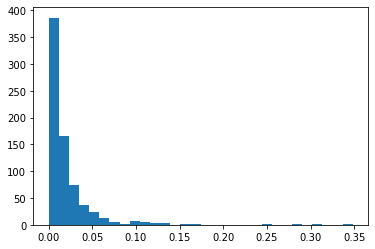

In [34]:
log_j_err = (np.log10(mydata['j_Ir_10Re_brT'] + mydata['j_Ir_10Re_brT_err']/2.0)) - (np.log10(mydata['j_Ir_10Re_brT'] - mydata['j_Ir_10Re_brT_err']/2.0))
print(max(log_j_err))
print(np.nanmean(log_j_err))
print(np.nanmedian(log_j_err))
plt.hist(log_j_err,bins=30)

0.348455875462756
0.020296706200148416
0.010971785105247323


<ipython-input-35-8eb376991a26>:1: RuntimeWarning: invalid value encountered in subtract
  log_j_err = (np.log10(mydata['j_mustar_10Re_brT'] + mydata['j_mustar_10Re_brT_err']/2.0)) - (np.log10(mydata['j_mustar_10Re_brT'] - mydata['j_mustar_10Re_brT_err']/2.0))


(array([386., 165.,  74.,  37.,  23.,  13.,   5.,   2.,   7.,   5.,   3.,
          3.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([0.        , 0.0116152 , 0.02323039, 0.03484559, 0.04646078,
        0.05807598, 0.06969118, 0.08130637, 0.09292157, 0.10453676,
        0.11615196, 0.12776715, 0.13938235, 0.15099755, 0.16261274,
        0.17422794, 0.18584313, 0.19745833, 0.20907353, 0.22068872,
        0.23230392, 0.24391911, 0.25553431, 0.2671495 , 0.2787647 ,
        0.2903799 , 0.30199509, 0.31361029, 0.32522548, 0.33684068,
        0.34845588]),
 <a list of 30 Patch objects>)

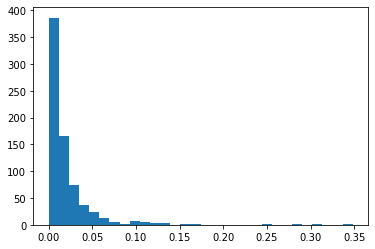

In [35]:
log_j_err = (np.log10(mydata['j_mustar_10Re_brT'] + mydata['j_mustar_10Re_brT_err']/2.0)) - (np.log10(mydata['j_mustar_10Re_brT'] - mydata['j_mustar_10Re_brT_err']/2.0))
print(max(log_j_err))
print(np.nanmean(log_j_err))
print(np.nanmedian(log_j_err))
plt.hist(log_j_err,bins=30)

In [36]:
# _________________________________________________________
# _________________________________________________________
#-- Calculating Disk Angular Momentum--#
# _________________________________________________________

for re in [3,5,10]:

    mydata['j_Ir_'+str(re)+'Re_brD'    ] = np.zeros(len(mydata['zSDSS']))
    mydata['j_mustar_'+str(re)+'Re_brD'] = np.zeros(len(mydata['zSDSS']))

    for i in range(len(mydata['zSDSS'])):
        if mydata['Model'][i] != 0:
            mydata['j_Ir_'+str(re)+'Re_brD'    ][i] = float('nan')
            mydata['j_mustar_'+str(re)+'Re_brD'][i] = float('nan')
        elif math.isnan(mydata['rot_velocity'][i]):
            mydata['j_Ir_'+str(re)+'Re_brD'    ][i] = float('nan')
            mydata['j_mustar_'+str(re)+'Re_brD'][i] = float('nan')  
        else:
            R       = np.array(R_kpc['D'][i])
            R_range = R[R<=re*mydata['reT_r_arcsec'][i]] 
            mydata['j_Ir_'+str(re)+'Re_brD'    ][i] = TotalSpecificAM(R_range,I_wrt_r['D']['r'][i][R<re*mydata['reT_r_arcsec'][i]],          
                                                                      ConstantV(R_range,mydata['rot_velocity'][i]))
            mydata['j_mustar_'+str(re)+'Re_brD'][i] = TotalSpecificAM(R_range,10**logMstar_wrt_r_fix['D'][i][R<re*mydata['reT_r_arcsec'][i]],
                                                                      ConstantV(R_range,mydata['rot_velocity'][i]))

print('Done :)')

<ipython-input-25-3784924be22e>:42: RuntimeWarning: invalid value encountered in multiply
  AM = NumericalIntegral(R,RC*SD*(R**2))


Done :)


In [37]:
# _________________________________________________________
# _________________________________________________________
#-- Calculating Angular Momentum for a non rotating bulge--#
# _________________________________________________________

for re in [3,5,10]:

    mydata['j_Ir_'+str(re)+'Re_bnrT'    ] = np.zeros(len(mydata['zSDSS']))
    mydata['j_mustar_'+str(re)+'Re_bnrT'] = np.zeros(len(mydata['zSDSS']))

    for i in range(len(mydata['zSDSS'])):
        if mydata['Model'][i] == 1:
            #If the galaxy is a pure disk then you can't seperate the bulge to make in non rotating and the answer is the same as the rotating bulge scenario
            mydata['j_Ir_'+str(re)+'Re_bnrT'    ][i] = mydata['j_Ir_'+str(re)+'Re_brT'    ][i]
            mydata['j_mustar_'+str(re)+'Re_bnrT'][i] = mydata['j_mustar_'+str(re)+'Re_brT'][i]
        if mydata['Model'][i] == 2:
            #If the galaxy is a pure bulge, then we are setting the net rotation to zero, and the angular momentum will be zero
            mydata['j_Ir_'+str(re)+'Re_bnrT'    ][i] = 0.0
            mydata['j_mustar_'+str(re)+'Re_bnrT'][i] = 0.0
        elif math.isnan(mydata['rot_velocity'][i]):
            mydata['j_Ir_'+str(re)+'Re_bnrT'    ][i] = float('nan')
            mydata['j_mustar_'+str(re)+'Re_bnrT'][i] = float('nan')  
        else:
            R       = np.array(R_kpc['D'][i])
            R_range = R[R<=re*mydata['reT_r_arcsec'][i]] 
            mydata['j_Ir_'+str(re)+'Re_bnrT'    ][i] = TotalSpecificAM_bnr(R_range,
                                                                           I_wrt_r['T']['r'][i][R<re*mydata['reT_r_arcsec'][i]],
                                                                           I_wrt_r['D']['r'][i][R<re*mydata['reT_r_arcsec'][i]],          
                                                                           ConstantV(R_range,mydata['rot_velocity'][i]))
            
            mydata['j_mustar_'+str(re)+'Re_bnrT'][i] = TotalSpecificAM_bnr(R_range,
                                                                           10**logMstar_wrt_r_fix['T'][i][R<re*mydata['reT_r_arcsec'][i]],
                                                                           10**logMstar_wrt_r_fix['D'][i][R<re*mydata['reT_r_arcsec'][i]],
                                                                           ConstantV(R_range,mydata['rot_velocity'][i]))

print('Done :)')

<ipython-input-25-3784924be22e>:56: RuntimeWarning: invalid value encountered in multiply
  AM = NumericalIntegral(R,RC*SD_disk*(R**2))


Done :)


In [38]:
#Save file

mydata['TotMstar_recover_fix']  = TotMstar_recover_fix['']
mydata['TotMstar_recover_fixD'] = TotMstar_recover_fix['D']
mydata['TotMstar_recover_fixT'] = TotMstar_recover_fix['T']

if MW_Extinction_On:
    #MW Extinction
    mydata.write(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v3.fits',overwrite=True)
else:
    #No MW Extinction
    mydata.write(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v3.fits',overwrite=True)


In [39]:
MW_Extinction_On

True

In [40]:
#-------------------
#-------------------
# Test Plots
#-------------------
#-------------------

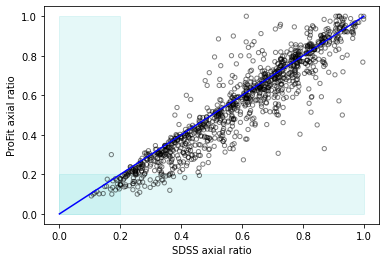

In [41]:
plt.fill_between([0,1],[0.2,0.2],color='c',alpha=0.1)
plt.fill_between([0,0.2],[1,1],  color='c',alpha=0.1)

plt.scatter(RepSample['expAB_r'][order_RepSample],mydata['axrat'],facecolors='none',edgecolors='k',s=18,alpha=0.5,label=None)
plt.plot([0,1],[0,1],color='b')

plt.xlabel('SDSS axial ratio')
plt.ylabel('ProFit axial ratio')
plt.savefig(path+'Figures/CompareAxialRatio.pdf')

<ipython-input-42-79216e088e33>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(RepSample['expAB_r'][order_RepSample][outlier1],mydata['axrat'][outlier1],color='k',marker='*',s=70,label=mydata['GASSID'][outlier1][0])
<ipython-input-42-79216e088e33>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(RepSample['expAB_r'][order_RepSample][outlier2],mydata['axrat'][outlier2],color='k',marker='s',s=60,label=mydata['GASSID'][outlier2][0])
<ipython-input-42-79216e088e33>:31: FutureWarning: Using a non-tuple sequence for 

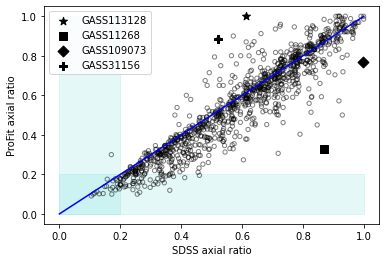

In [42]:
#Identify some outliers to look at in more depth
outlier1_a = np.argwhere(mydata['i']<0.5)
outlier1_b = np.argwhere(RepSample['expAB_r'][order_RepSample]<0.8)

outlier1 = intersection(outlier1_a,outlier1_b)

outlier2_a = np.argwhere(mydata['axrat']<0.4)
outlier2_b = np.argwhere(RepSample['expAB_r'][order_RepSample]>0.8)

outlier2 = intersection(outlier2_a,outlier2_b)

outlier3_a = np.argwhere(mydata['axrat']<0.8)
outlier3_b = np.argwhere(RepSample['expAB_r'][order_RepSample]>0.98)

outlier3 = intersection(outlier3_a,outlier3_b)

outlier4_a = np.argwhere(mydata['axrat']>0.8)
outlier4_b = np.argwhere(RepSample['expAB_r'][order_RepSample]<0.53)

outlier4 = intersection(outlier4_a,outlier4_b)

#-----------------------------------------------------------------

plt.fill_between([0,1],[0.2,0.2],color='c',alpha=0.1)
plt.fill_between([0,0.2],[1,1],  color='c',alpha=0.1)

plt.scatter(RepSample['expAB_r'][order_RepSample],mydata['axrat'],facecolors='none',edgecolors='k',s=18,alpha=0.5,label=None)

plt.scatter(RepSample['expAB_r'][order_RepSample][outlier1],mydata['axrat'][outlier1],color='k',marker='*',s=70,label=mydata['GASSID'][outlier1][0])
plt.scatter(RepSample['expAB_r'][order_RepSample][outlier2],mydata['axrat'][outlier2],color='k',marker='s',s=60,label=mydata['GASSID'][outlier2][0])
plt.scatter(RepSample['expAB_r'][order_RepSample][outlier3],mydata['axrat'][outlier3],color='k',marker='D',s=60,label=mydata['GASSID'][outlier3][0])
plt.scatter(RepSample['expAB_r'][order_RepSample][outlier4],mydata['axrat'][outlier4],color='k',marker='P',s=60,label=mydata['GASSID'][outlier4][0])

plt.plot([0,1],[0,1],color='b')

plt.legend()

plt.xlabel('SDSS axial ratio')
plt.ylabel('ProFit axial ratio')
plt.savefig(path+'Figures/CompareAxialRatio+Outliers.pdf')

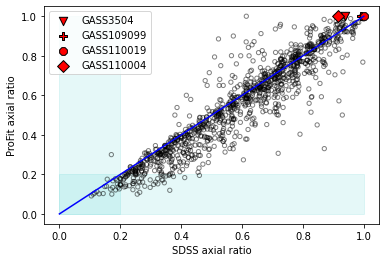

In [43]:
plt.fill_between([0,1],[0.2,0.2],color='c',alpha=0.1)
plt.fill_between([0,0.2],[1,1],  color='c',alpha=0.1)

plt.scatter(RepSample['expAB_r'][order_RepSample],mydata['axrat'],facecolors='none',edgecolors='k',s=18,alpha=0.5,label=None)

plt.plot([0,1],[0,1],color='b')

for gassid,shape in zip(['GASS3504','GASS109099','GASS110019','GASS110004'],['v','P','8','D']):
    idx = np.argwhere(mydata['GASSID']==gassid)
    plt.scatter(RepSample['expAB_r'][order_RepSample][idx],mydata['axrat'][idx],facecolors='r',edgecolors='k',marker=shape,s=70,label=gassid)

plt.legend()

plt.xlabel('SDSS axial ratio')
plt.ylabel('ProFit axial ratio')
plt.savefig(path+'Figures/CompareAxialRatio+Outliers2.pdf')

In [44]:
#create a new fits file called "xGASS_AM_catalogue.fits"

#Add in the columns and metadata I want for the catalogue:
#-----------------------
# [C] -> component (B,D,T)
# [B] -> SDSS band (g,r,i)

# -- General Global parameters (from either xGASS catalogue or Cook 2019)
#GASSID
#RA
#DEC
#zSDSS
#i                         - inclination (Catinella+2018)
#RMS                       - error floor in apparent mags 
#deltaV                    - final resolution after smoothing (Catinella+2018)
#model                     - either 0 (2-comp), 1 (pure-disk), or 2 (pure-bulge) (Cook+2019)
#magzero_[B]               - magnitude zero (Cook+2019)
#nser[C]_[B]              - sersic index (Cook+2019)

#-- Size, magnitude, g-i colour, masses & rotational velocity(combo of Cook 2019 & my own calculations)
#re[C]_[B]                - half light radius [kpc] (Cook+2019)
#rm[C]_[B]                - half mass radius  [kpc] (after correction for colour to be constant for when the surface density profile is less than the RMS)
#mag[C]_[B]               - apparent magnitude (Cook+2019)
#abmag[C]_[B]             - absolute magnitude (Hardwick+InPrep)
#lgMstar[C]               - total log_10(Mstar) [Msun] (Hardwick+InPrep)
#vrot                     - rotational velocity [km.s^-1] (Hardwick+InPrep)

#-- Angular momentum
# [P] -> what profile is being used; either Ir (for Intensity profile in r-band) or mustar (for the stellar mass surface density profile)
# [#] -> number of Re the profile is integrated to (10 ~ total)
# [R] -> either br (bulge rotating) or bnr (bulge not rotating)

#j_[P]_[#]Re_[R][C]        - Specific AM (Hardwick+InPrep)



In [45]:
#THIS IS DRIVING ME CRAZY D: come back to later...

from astropy.table import Table

keys = ('GASSID','RA','DEC','zSDSS','i','RMS','deltaV','Model','magzero_g','magzero_r','magzero_i',
                'nser_g','nser_r','nser_i','nserB_g','nserB_r','nserB_i','nserD_g','nserD_r','nserD_i')

newtable = Table(mydata[keys],
                 names = keys,)

newtable['vrot']    = np.zeros(len(newtable['GASSID']))
for c in ('B','D','T'):
    newtable['lgMstar'+c]    = np.zeros(len(newtable['GASSID']))
    for b in ('g','r','i'):
        newtable['re'+c+'_'+b]    = np.zeros(len(newtable['GASSID']))
        newtable['rm'+c+'_'+b]    = np.zeros(len(newtable['GASSID']))
        newtable['mag'+c+'_'+b]   = np.zeros(len(newtable['GASSID']))
        newtable['abmag'+c+'_'+b] = np.zeros(len(newtable['GASSID']))

for i in range(len(newtable['GASSID'])):
    if newtable['Model'][i] == 0:
        #If it is a two component system then:
        for b in ('g','r','i'):
            newtable['reB_'+b][i] = mydata['reB_'+b+'_kpc'][i]
            newtable['reD_'+b][i] = mydata['reD_'+b+'_kpc'][i]
            newtable['reT_'+b][i] = mydata['reT_'+b+'_kpc'][i]
    elif newtable['Model'][i] == 1:
        for b in ('g','r','i'):
            newtable['reB_'+b][i] = float('nan')
            newtable['reD_'+b][i] = float('nan')
            newtable['reT_'+b][i] = mydata['re_'+b+'_kpc'][i]
    elif newtable['Model'][i] == 2:
        for b in ('g','r','i'):
            newtable['reB_'+b][i] = float('nan')
            newtable['reD_'+b][i] = float('nan')
            newtable['reT_'+b][i] = mydata['re_'+b+'_kpc'][i]
    else:
        for b in ('g','r','i'):
            newtable['reB_'+b][i] = float('nan')
            newtable['reD_'+b][i] = float('nan')
            newtable['reT_'+b][i] = float('nan')


KeyError: 'deltaV'

In [ ]:
newtable['j_Ir_10Re_brT']= mydata['TotSpecificAM_sd']
newtable['j_mustar_10Re_brT']= mydata['TotSpecificAM_StellarM']

newtable['j_Ir_10Re_brD']     = mydata['DiskSpecificAM_sd'][i] 
newtable['j_mustar_10Re_brD'] = mydata['DiskSpecificAM_sd'][i] 

In [ ]:
newtable